In [47]:
import numpy as np

data = np.load("dataset/s03_1.npy")
data.shape

(8, 1600, 4)

### Funções de filtragem do domínio do tempo

In [48]:
from scipy import signal


# definições de filtros
def butter_bandpass(data, lowcut, highcut, fs=200, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandpass')
    return signal.filtfilt(b, a, data, padlen=len(data) // 2)

def butter_notch(data, cutoff, var=1, fs=200, order=4):
    nyq = fs * 0.5
    low = (cutoff - var) / nyq
    high = (cutoff + var) / nyq
    b, a = signal.iirfilter(order, [low, high], btype='bandstop', ftype="butter")
    return signal.filtfilt(b, a, data, padlen=len(data) // 2)

Aplicação dos filtros temporais nos dados

In [49]:
data = data.transpose(0, 2, 1)
print(data.shape)

data_filtered = butter_notch(data, 60)
data_filtered = butter_bandpass(data_filtered, 5., 50.)

from copy import deepcopy
data = deepcopy(data_filtered)


(8, 4, 1600)


### Segmentação dos dados

In [50]:
from scipy.signal import stft

step = 103
segment = 256
print('', data.shape)

n_win = int((data.shape[-1] - segment) / step) + 1
ids = np.arange(n_win) * step

# Janelas do dado no dominio do tempo
chunks_time = np.array([data[:,:,k:(k + segment)] for k in ids]).transpose(1, 2, 0, 3)

# Janelas do dado no domínio da frequência
_, _, chunks_freq = stft(data, fs=200, nperseg=256, noverlap=128)
chunks_freq = np.swapaxes(chunks_freq, 2, 3)

print('Formato (shape) dos dados depois da divisão de janelas')
print(f'Dominio do tempo: {chunks_time.shape} - (classes+ensaios, canais, janelas, linhas)')
print(f'Dominio da frequência:  {chunks_freq.shape} - (classes+ensaios, canais, janelas, linhas)')

 (8, 4, 1600)
Formato (shape) dos dados depois da divisão de janelas
Dominio do tempo: (8, 4, 14, 256) - (classes+ensaios, canais, janelas, linhas)
Dominio da frequência:  (8, 4, 14, 129) - (classes+ensaios, canais, janelas, linhas)


### Definição de algumas funções para aplicação de características

Uma característica é uma propriedade individual mensurável ou característica de um fenômeno que está sendo observado. Em EMG, uma característica pode ser extraída no domínio do tempo ou no domínio da frequência. As características a seguir foram retiradas do artigo *EMG Feature Extraction for Tolerance of White Gaussian Noise* \[1\].

### Domínio do tempo

1. Variance of EMG (VAR)

    > $ \frac{1}{N-1}\sum_{i=1}^{N}x_i^2 $

2. Root Mean Square (RMS)

    > $ \sqrt{\frac{1}{N}\sum_{i=1}^{N}|x_i|^2} $

3. Waveform Length (WL)
    
    > $ \sum_{i=1}^{N-1}|x_{i+1} - x_i| $

4. Zero Crossing (ZC)

    > $ \sum_{i=1}^{N}sgn(x_i) $
    
    > $ sgn(x) = \begin{cases} 1 & \text{if } x_i * x_{i+1} \leq 0 \\ 0 & \text{otherwise} \end{cases} $

### Domínio da frequência

1. Median Frequency (FMD)

    > $ \frac{1}{2}\sum_{j=1}^{M}PSD_j $

2. Mean Frequency (FMN)

    > $ \sum_{j=1}^{M} f_j PSD_j \Big/ \sum_{j=1}^{M} PSD_j $
    
    > $ f_j = j \cdot \frac{SampleRate}{2 \cdot M} $

3. Modified Median Frequency (MMDF)

    > $ \frac{1}{2}\sum_{j=1}^{M}A_j $
    
    > $ A_j = Amplitude\ do\ espectro\ j $

4. Modified Frequency Mean (MMNF)

    > $ \sum_{j=1}^{M} f_j A_j \Big/ \sum_{j=1}^{M} A_j $


\[1\] Phinyomark, Angkoon & Limsakul, Chusak & Phukpattaranont, P.. (2008). EMG Feature Extraction for Tolerance of White Gaussian Noise.
[Disponível neste link](https://www.researchgate.net/publication/263765853_EMG_Feature_Extraction_for_Tolerance_of_White_Gaussian_Noise)

É necessário implementar as características, geralmente em formato de funções ou métodos, para que seja possível aplicar tais funções aos dados de entrada e obter as características resultantes. A seguir temos a implementação das características VAR & RMS (domínio do tempo) e FDM & MMDF (domínio da frequência).

In [51]:
from math import prod

# funções auxiliares
def PSD(w):
    ''' definição da função PSD para o sinal no domínio da frequência '''
    return np.abs(w) ** 2

# funções de extração de características

def var(x):
    return np.sum(x ** 2, axis=-1) / (np.prod(x.shape) - 1)

def rms(x):
    return np.sqrt(np.sum(np.abs(x) ** 2, axis=-1) / (np.prod(x.shape)))

def fmd(w):
    return np.sum(PSD(w), axis=-1) / 2

def mmdf(w):
    return np.sum(np.abs(w), axis=-1) / 2

2. Implementar as outras 4 caraterísticas

In [52]:
def wl(x):
    return np.sum(np.abs(np.diff(x, axis=-1)), axis=-1)

def zc(x):
    return np.sum(np.diff(np.sign(x), axis=-1) != 0, axis=-1)

def fmn(w, fs=200):
    M = w.shape[-1]
    f = np.arange(M) * (fs / (2 * M))
    return np.sum(f * PSD(w), axis=-1) / np.sum(PSD(w), axis=-1)

def mmnf(w, fs=200):
    M = w.shape[-1]
    f = np.arange(M) * (fs / (2 * M))
    return np.sum(f * np.abs(w), axis=-1) / np.sum(np.abs(w), axis=-1)

1. Adicionar demais trials

In [53]:
import glob
data_files = glob.glob("dataset/s03_*.npy")

all_features = []
all_labels = []

# Processar cada arquivo
for file_path in data_files:
    # Carregar dados
    data = np.load(file_path)
    data = data.transpose(0, 2, 1)

    # Aplicar filtros
    data_filtered = butter_notch(data, 60)
    data_filtered = butter_bandpass(data_filtered, 5., 50.)

    # Segmentação
    step = 103
    segment = 256
    n_win = int((data_filtered.shape[-1] - segment) / step) + 1
    ids = np.arange(n_win) * step

    # Janelas no domínio do tempo
    chunks_time = np.array([data_filtered[:,:,k:(k + segment)] for k in ids]).transpose(1, 2, 0, 3)

    # Janelas no domínio da frequência
    _, _, chunks_freq = stft(data_filtered, fs=200, nperseg=256, noverlap=128)
    chunks_freq = np.swapaxes(chunks_freq, 2, 3)

    # Extrair características
    features = []
    for i in range(chunks_time.shape[1]):
        # Características no domínio do tempo
        var_feat = var(chunks_time[:,i,:,:])
        rms_feat = rms(chunks_time[:,i,:,:])
        wl_feat = wl(chunks_time[:,i,:,:])
        zc_feat = zc(chunks_time[:,i,:,:])

        # Características no domínio da frequência
        fmd_feat = fmd(chunks_freq[:,i,:,:])
        fmn_feat = fmn(chunks_freq[:,i,:,:])
        mmdf_feat = mmdf(chunks_freq[:,i,:,:])
        mmnf_feat = mmnf(chunks_freq[:,i,:,:])

        # Concatenar características
        channel_features = np.column_stack([
            var_feat, rms_feat, wl_feat, zc_feat,
            fmd_feat, fmn_feat, mmdf_feat, mmnf_feat
        ])
        features.append(channel_features)

    features = np.hstack(features)
    all_features.append(features)

    # Criar rótulos
    labels = np.repeat(np.arange(8), features.shape[0]//8)
    all_labels.append(labels)

3. Aplicar o classificador SVM (básico) já com o vetor de rótulos criado.

In [54]:
# Concatenar todos os dados
X = np.vstack(all_features)
y = np.concatenate(all_labels)

# Dividir em treino e teste
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Treinar SVM
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

# Avaliar
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia do classificador SVM: {accuracy:.2%}")

Acurácia do classificador SVM: 50.00%


## Vetor de características

Ao final da implementação e seleção das características, deve ser escolhida as características e então teremos um vetor com todas elas implementadas.

O vetor de características estará organizado da seguinte forma (evisemplo p/ VAR, RMS, RDM e MMDF):

| ID sample | VAR1 | RMS1 | FMD1 | MMDF1 | VAR2 | RMS2 | FMD2 | MMDF2 | Classe |
|:---------:|:----:|:----:|:----:|:-----:|------|------|------|-------|:------:|
|     1     |  v1  |  v1  |  v1  |   v1  | v1   | v1   | v1   | v1    |    0   |
|     2     |  v2  |  v2  |  v2  |   v2  | v2   | v2   | v2   | v2    |    0   |
|    ...    |  ... |  ... |  ... |  ...  | ...  | ...  | ...  | ...   |   ...  |
|     N     |  vN  |  vN  |  vN  |   vN  | vN   | vN   | vN   | vN    |    7   |

## Implementação do vetor

In [55]:
final_data = list()

final_data.append(var(chunks_time))
final_data.append(rms(chunks_time))
final_data.append(wl(chunks_time))
final_data.append(zc(chunks_time))

final_data.append(fmd(chunks_freq))
final_data.append(mmdf(chunks_freq))
final_data.append(fmn(chunks_freq))
final_data.append(mmnf(chunks_freq))

final = np.array(final_data)
final.shape

(8, 8, 4, 14)

É necessário que seja reordenado as dimensões do vetor de características, pois cada característica (de cada canal), deve corresponder à última dimensão do vetor. Por fim, as outras dimensões são concatenadas para o número de amostras.

In [56]:
vis = final.transpose(1, 3, 2, 0)
print('Formato dos dados depois da extração de características')
print(f'{vis.shape} - (classes, janelas, eletrodos, características)')

X = vis.reshape(vis.shape[0] * vis.shape[1], vis.shape[2] * vis.shape[3])
print('Formato para classificação:', X.shape)

Formato dos dados depois da extração de características
(8, 14, 4, 8) - (classes, janelas, eletrodos, características)
Formato para classificação: (112, 32)


### Visualização das características

Desenvolvemos aqui uma função que demonstra as amostras em um `scatter plot` bidimensional.

Para que isso fosse possível nos dados, o plot foi organizado de tal forma que, a bidimensionalidade foi organizada por meio dos dois canais presentes no _dataset_.

**Observação**: para que a mesma análise visual seja criada em dados com múltiplos canais, é necessário que seja utilizado uma redução dos N canais em apenas dois. Um método que pode ser utilizado para esta finalidade é o *Principal Component Analisys* (PCA).

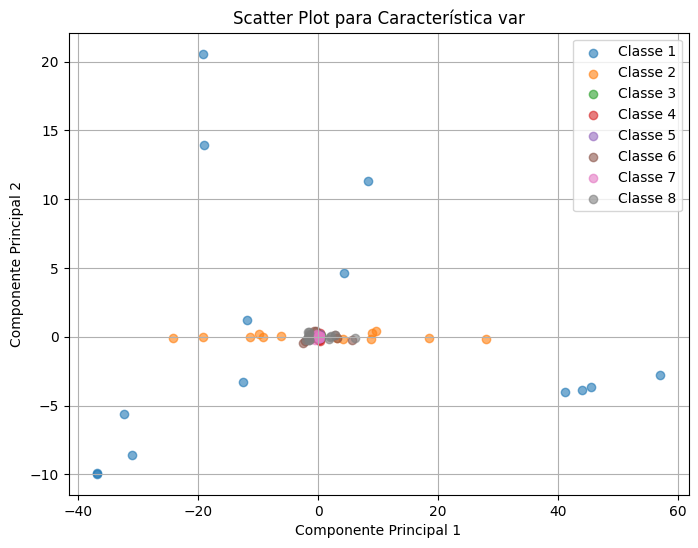

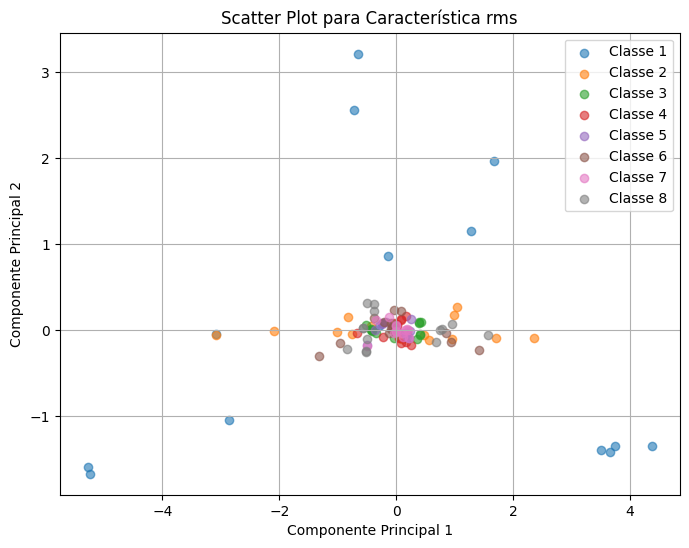

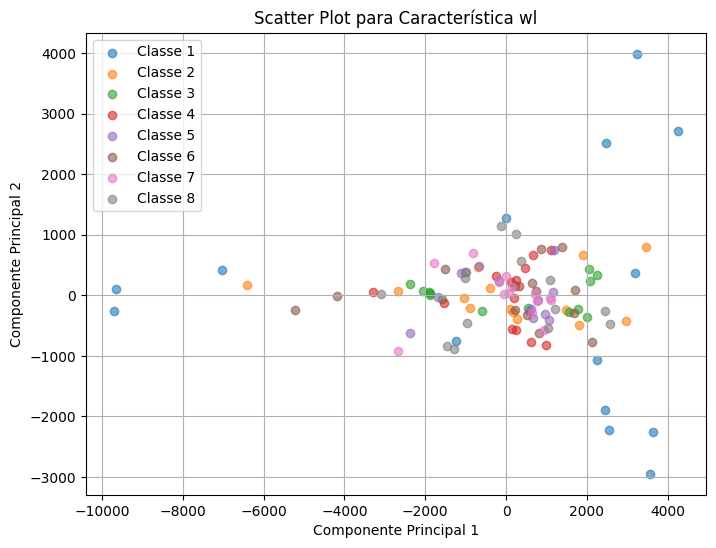

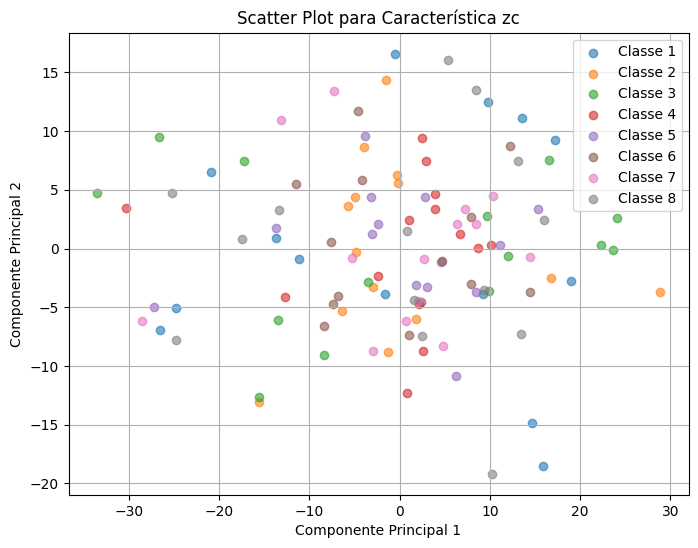

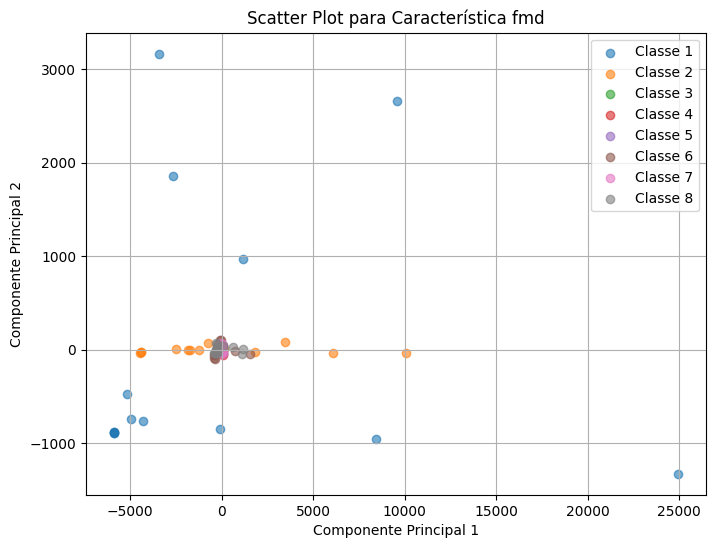

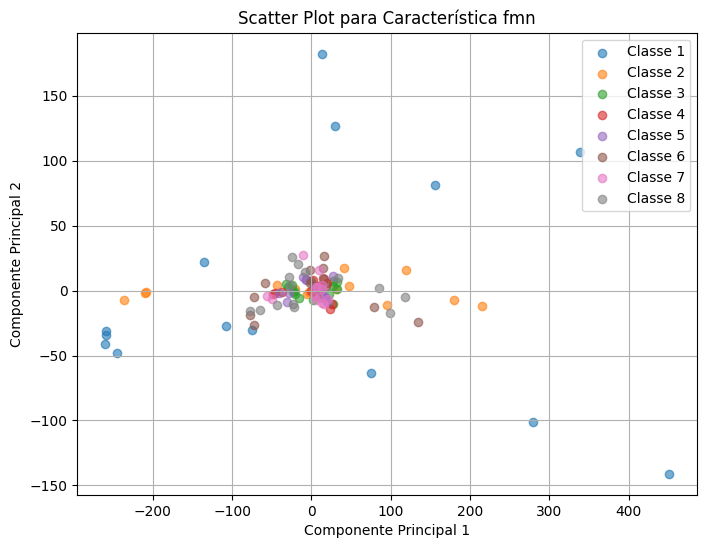

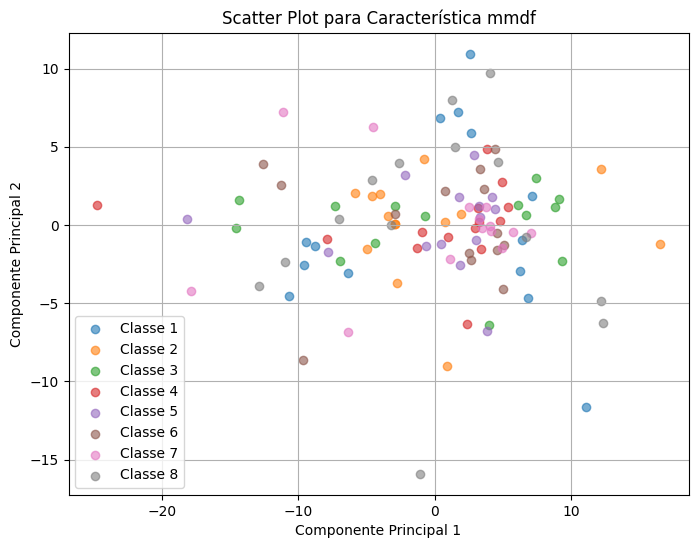

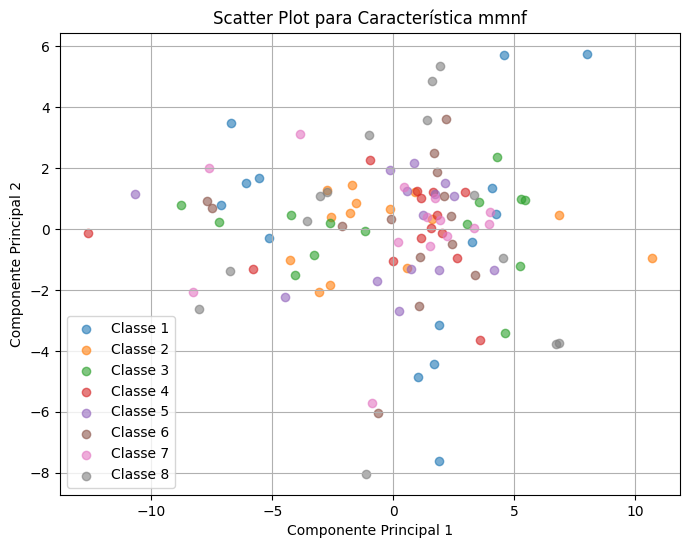

In [57]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Initialize PCA with 2 components
pca = PCA(n_components=2)

feature_names = ['var', 'rms', 'wl', 'zc', 'fmd', 'fmn', 'mmdf', 'mmnf']

# Iterar sobre as 4 características
for feature_idx in range(8):
    plt.figure(figsize=(8, 6))
    for class_idx in range(8):  # Iterar sobre as 8 classes
        # Selecionar os dados da classe e característica atual
        data = vis[class_idx, :, :, feature_idx]
        # Aplicar PCA para reduzir de 4 para 2 dimensões
        data_pca = pca.fit_transform(data.reshape(-1, 4))
        # Scatter plot para a classe atual
        plt.scatter(data_pca[:, 0], data_pca[:, 1], label=f'Classe {class_idx + 1}', alpha=0.6)

    plt.title(f'Scatter Plot para Característica {feature_names[feature_idx]}')
    plt.xlabel('Componente Principal 1')
    plt.ylabel('Componente Principal 2')
    plt.legend()
    plt.grid(True)
    plt.show()

In [61]:
# === IMPORTAÇÕES ===
import numpy as np
from scipy.signal import iirnotch, butter, filtfilt
from numpy.fft import rfft
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# === FUNÇÕES DE FILTRO ===
def butter_notch(data, notch_freq=60, fs=200, quality=30):
    b, a = iirnotch(notch_freq, quality, fs)
    return filtfilt(b, a, data, axis=0)

def butter_bandpass(data, lowcut=5, highcut=50, fs=200, order=4):
    nyq = fs / 2
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data, axis=0)

# === EXTRAÇÃO DE CARACTERÍSTICAS ===
def PSD(w):
    return np.abs(w)**2

def var(x):
    return np.sum(x**2, axis=-1) / (np.prod(x.shape) - 1)

def rms(x):
    return np.sqrt(np.mean(x**2, axis=-1))

def wl(x):
    return np.sum(np.abs(np.diff(x, axis=-1)), axis=-1)

def zc(x):
    return np.sum(np.diff(np.sign(x), axis=-1) != 0, axis=-1)

def fmn(w, fs=200):
    M = w.shape[-1]
    f = np.arange(M) * (fs / (2 * M))
    psd = PSD(w)
    return np.sum(f * psd, axis=-1) / np.sum(psd, axis=-1)

def fmd(w, fs=200):
    M = w.shape[-1]
    f = np.arange(M) * (fs / (2 * M))
    psd = PSD(w)
    fmn_ = fmn(w, fs=fs)[..., np.newaxis]
    return np.sqrt(np.sum(((f - fmn_)**2) * psd, axis=-1) / np.sum(psd, axis=-1))

def mmnf(w):
    psd = PSD(w)
    bins = np.arange(w.shape[-1])
    return np.sum(bins * psd, axis=-1) / np.sum(psd, axis=-1)

def mmdf(w):
    psd = PSD(w)
    bins = np.arange(w.shape[-1])
    mmnf_ = mmnf(w)[..., np.newaxis]
    return np.sqrt(np.sum((bins - mmnf_)**2 * psd, axis=-1) / np.sum(psd, axis=-1))

# === SEGMENTAÇÃO ===
def segmentar(data, segment=256, step=103):
    n_win = int((data.shape[0] - segment) / step) + 1
    ids = np.arange(n_win) * step
    chunks_time = np.array([data[k:(k + segment), :].T for k in ids])
    chunks_freq = rfft(chunks_time, axis=-1)
    return chunks_time, chunks_freq

# === CARREGAMENTO E TREINAMENTO ===
data = np.load("dataset/s03_1.npy").reshape(8, 1600, 4)

all_features = []
all_labels = []
for class_idx in range(8):
    signal = data[class_idx]
    signal = butter_notch(signal)
    signal = butter_bandpass(signal)
    chunks_time, chunks_freq = segmentar(signal)

    features = []
    features.append(var(chunks_time))
    features.append(rms(chunks_time))
    features.append(wl(chunks_time))
    features.append(zc(chunks_time))
    features.append(fmd(chunks_freq))
    features.append(mmdf(chunks_freq))
    features.append(fmn(chunks_freq))
    features.append(mmnf(chunks_freq))
    features = np.stack(features, axis=-1)

    X_class = features.reshape(features.shape[0], -1)
    y_class = np.full(X_class.shape[0], class_idx)

    all_features.append(X_class)
    all_labels.append(y_class)

X = np.vstack(all_features)
y = np.concatenate(all_labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia do classificador SVM: {accuracy:.2%}")

# === SIMULAÇÃO EM TEMPO REAL ===
stream_data = np.load("dataset/s03_1.npy").reshape(-1, 4)
buffer_size = 1600

for i in range(0, stream_data.shape[0], buffer_size):
    buffer = stream_data[i:i+buffer_size]
    if buffer.shape[0] < buffer_size:
        break

    buffer_filt = butter_notch(buffer)
    buffer_filt = butter_bandpass(buffer_filt)
    chunks_time, chunks_freq = segmentar(buffer_filt)

    features = []
    features.append(var(chunks_time))
    features.append(rms(chunks_time))
    features.append(wl(chunks_time))
    features.append(zc(chunks_time))
    features.append(fmd(chunks_freq))
    features.append(mmdf(chunks_freq))
    features.append(fmn(chunks_freq))
    features.append(mmnf(chunks_freq))
    features = np.stack(features, axis=-1)

    X_stream = features.reshape(features.shape[0], -1)

    y_pred = svm.predict(X_stream)
    print(f"Buffer {i//buffer_size + 1}: Predições ->", y_pred)





Acurácia do classificador SVM: 82.35%
Buffer 1: Predições -> [0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Buffer 2: Predições -> [1 1 1 1 2 1 1 1 1 1 1 1 1 1]
Buffer 3: Predições -> [2 2 2 2 2 2 2 2 2 2 2 2 2 2]
Buffer 4: Predições -> [3 3 3 4 3 1 3 3 3 3 3 3 3 3]
Buffer 5: Predições -> [4 4 4 4 4 4 4 4 4 4 4 4 4 4]
Buffer 6: Predições -> [5 5 5 5 5 5 5 0 5 5 0 0 5 5]
Buffer 7: Predições -> [6 6 6 6 6 6 6 6 6 6 6 6 6 6]
Buffer 8: Predições -> [7 7 7 7 7 7 7 7 7 7 7 7 7 7]
